# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 8
## Testing Early Stopping and Model Saving

One thing of note, some models are over training while some likely could use more epochs from our best run.  It's time to figure out how to implement early stopping in fastai.  This technique allows you to train with a maximum number of epochs while terminating after a few epochs have not produced any benefit / negative benefit.  Model saving ensures that you return the model that provided the best result as per the tracked metric.  We do have an important decision to make regarding whether to use validation loss or error_rate/accuracy to determine a stopping criteria.  Typically, validation loss would be used but my gut feeling is that accuracy will produce better results.  Given the limited time until the competition ends we may have to limit our experiments as there are a few other ideas I have that may also give final minute gains to our accuracy scores.

## Setup Competition Files

In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [2]:
comp = 'kaggle-pog-series-s01e03'

In [3]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [4]:
import timm
from fastai.vision.all import *
set_seed(42)

# path.ls()

In [5]:
csv_path = path/'corn'

In [6]:
trn_path = csv_path/'train'
# trn_path.ls()

In [7]:
tst_path = csv_path/'test'
# tst_path.ls()

Grab csv lists

In [8]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
trn_files = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
tst_files = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

Let's do a quick test on a subset of the data

In [17]:
trn_files = trn_files.sample(1000)
# trn_files

## Default Trainer
Set up a trainer (without early stopping and model saving)

In [10]:
def train_accum(arch, batch=aug_transforms(size=256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42):
    dls = ImageDataLoaders.from_df(trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    if finetune:
        learn.fine_tune(epochs, _slide)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide)
    return learn#, learn.tta(dl=dls.test_dl(tst_files)) #Remove TTA for these tests

epoch,train_loss,valid_loss,accuracy,time
0,1.063868,0.813269,0.686453,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.706793,0.670444,0.728701,00:42
1,0.632247,0.663231,0.728352,00:42
2,0.574550,0.603808,0.766411,00:42
3,0.530840,0.637923,0.758729,00:42
4,0.473407,0.573287,0.782472,00:42
5,0.407088,0.597831,0.782472,00:42
6,0.340689,0.651742,0.781425,00:42
7,0.286201,0.663017,0.789106,00:42
8,0.218725,0.711107,0.787709,00:42
9,0.187369,0.739087,0.783869,00:42


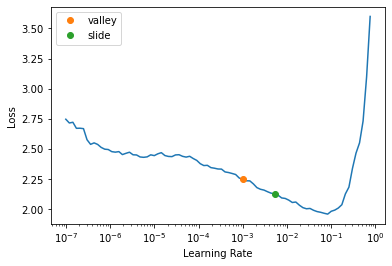

In [11]:
arch = 'convnext_small_in22k'
train_accum(arch)

## Early Stopping Trainer
Set up a trainer (with early stopping and model saving).  Doing something similar to what's shown [here](https://towardsdatascience.com/using-fastai-callbacks-for-efficient-model-training-cb03160a5f17).

In [27]:
def train_accum_es(arch, batch=aug_transforms(size=256), item=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Border), accum=1, finetune=True, epochs=12, new_seed=42, early_stop=True, monitor='accuracy', min_delta=0.01, patience=3):
    dls = ImageDataLoaders.from_df(trn_files, seed=new_seed,
        path=csv_path, fn_col=2, label_col=3,
        valid_pct=0.2, item_tfms=item,
        batch_tfms=batch,
        bs=64//accum)
    cbs = GradientAccumulation(64) if accum else []
    learn = vision_learner(dls, arch, metrics=accuracy, cbs=cbs).to_fp16()
    _valley, _slide = learn.lr_find(suggest_funcs=(valley,slide))
    train_cbs = [EarlyStoppingCallback(monitor=monitor, min_delta=min_delta, patience=patience),SaveModelCallback(monitor=monitor, min_delta=min_delta)] if early_stop else []
    if finetune:
        learn.fine_tune(epochs, _slide, cbs=train_cbs)
    else:
        learn.unfreeze()
        learn.fit_one_cycle(epochs, _slide, cbs=train_cbs)
    return learn#, learn.tta(dl=dls.test_dl(tst_files)) #Remove TTA for these tests

Test in non-es configuration:

epoch,train_loss,valid_loss,accuracy,time
0,2.151748,2.029294,0.425000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,1.422369,1.520325,0.475000,00:03
1,1.430200,1.303383,0.540000,00:03
2,1.383286,1.324033,0.535000,00:03
3,1.319931,1.152270,0.580000,00:03
4,1.219289,1.020124,0.600000,00:03
5,1.124638,1.064209,0.630000,00:03
6,1.041049,1.118739,0.635000,00:03
7,0.949600,1.082897,0.670000,00:03
8,0.861896,1.071651,0.640000,00:03
9,0.802859,1.073301,0.650000,00:03


GPU:0
process     518485 uses     1877.000 MB GPU memory
process     840829 uses    12297.000 MB GPU memory


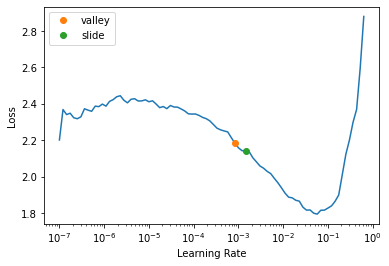

In [18]:
import gc

learn=train_accum_es(arch, epochs=20, early_stop=False)
print(learn.validate())

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

Test with default early stopping (20 epochs):

epoch,train_loss,valid_loss,accuracy,time
0,2.138459,2.405847,0.335000,00:03


Better model found at epoch 0 with accuracy value: 0.33500000834465027.


epoch,train_loss,valid_loss,accuracy,time
0,1.546496,1.768571,0.405000,00:03
1,1.545463,1.450012,0.460000,00:03
2,1.437248,1.305364,0.500000,00:03
3,1.343037,1.075035,0.595000,00:03
4,1.224009,1.027885,0.635000,00:03
5,1.140171,1.054361,0.620000,00:03
6,1.052247,1.156551,0.590000,00:03
7,0.985743,1.222855,0.620000,00:03


Better model found at epoch 0 with accuracy value: 0.4050000011920929.
Better model found at epoch 1 with accuracy value: 0.46000000834465027.
Better model found at epoch 2 with accuracy value: 0.5.
Better model found at epoch 3 with accuracy value: 0.5950000286102295.
Better model found at epoch 4 with accuracy value: 0.6349999904632568.
No improvement since epoch 4: early stopping


[1.027884840965271, 0.6349999904632568]
GPU:0
process     518485 uses     1877.000 MB GPU memory
process     840829 uses    11707.000 MB GPU memory


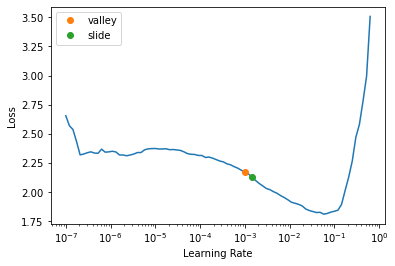

In [29]:
learn = train_accum_es(arch, early_stop=True, patience=3, epochs=20)
print(learn.validate())

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

Validation generated from returned learner shows same results as epoch 4.  Early stopping / model saving seems to be working!

Try early stopping with fit_one_cycle as well.

epoch,train_loss,valid_loss,accuracy,time
0,2.312679,1.726173,0.445000,00:03
1,2.134329,12.348537,0.070000,00:03
2,2.049910,58.129219,0.070000,00:03
3,1.983147,87.193436,0.405000,00:03


Better model found at epoch 0 with accuracy value: 0.4449999928474426.
No improvement since epoch 0: early stopping


[1.7261730432510376, 0.4449999928474426]
GPU:0
process     518485 uses     1877.000 MB GPU memory
process     840829 uses    11707.000 MB GPU memory


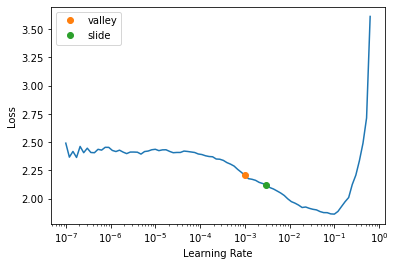

In [30]:
learn = train_accum_es(arch, epochs=20, finetune=False)
print(learn.validate())

# Attempt to clear GPU memory (as best we can)
del(learn)
print(torch.cuda.list_gpu_processes())
gc.collect()
torch.cuda.empty_cache()

Early stopping working (even though fit_one_cycle caused errors to explode).  Should use this going forward!